In [1]:
%run ../macro_tQ.py
import sys
sys.path.append('../')
import macro_tQ as tQ

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

In [2]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

def random_linear_oracle(n):  #n es la longitud de la cadena a oculta

    import random, string
    a = ''.join(random.choices(['0','1'], k=n))
    print('cadena oculta=',a)  
    qc = QuantumCircuit(n+1) # el ultimo registro es la salida |f(x)> = |a.x>

    
    for i, ai in enumerate(reversed(a)):  # ponemos reversed para usar el convenio de qiskit
        if ai == '1':
            qc.cx(i,n)    
    return qc

random_linear_oracle(4).draw()
    

cadena oculta= 0010


q_0: ─────
          
q_1: ──■──
       │  
q_2: ──┼──
       │  
q_3: ──┼──
     ┌─┴─┐
q_4: ┤ X ├
     └───┘

In [3]:
def BV_circuit(linear_oracle,n):
    #n: número de bits
    #a: coeficiente oculto
    #return: circuito

    qreg = QuantumRegister(n+1)
    creg = ClassicalRegister(n)
    qc = QuantumCircuit(qreg,creg)

    #Hacemos máxima superposición
    qc.h(qreg)

    #Ponemos el último qubit en el estado |->
    qc.z(qreg[-1])

    qc.barrier()
    
    # añadimos el oráculo lineal con la cadena oculta
    qc.append(linear_oracle.to_gate(),qreg[:])
    
    qc.barrier()
    

    #Aplicamos Hadamard de nuevo

    qc.h(qreg[0:-1])

    qc.measure(qreg[0:-1],creg)

    return qc

cadena oculta= 0011


/opt/anaconda3/envs/TalentQ/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


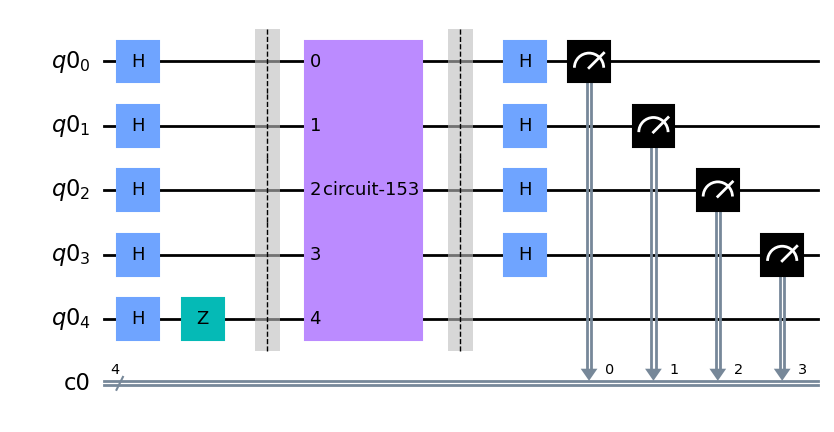

In [4]:
n = 4
linear_oracle = random_linear_oracle(n)

circuito = BV_circuit(linear_oracle,n)

circuito.draw(output = 'mpl')

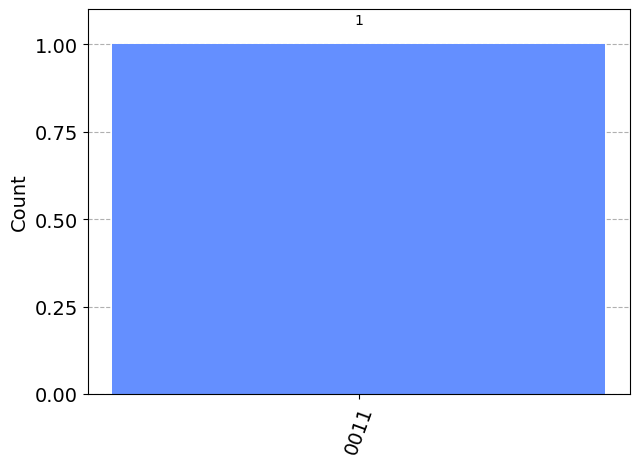

In [5]:
from qiskit import execute, Aer
simulator = Aer.get_backend('qasm_simulator')

job = execute(circuito,simulator,shots = 1)
cuentas = job.result().get_counts(circuito)

from qiskit.tools.visualization import plot_histogram
plot_histogram(cuentas) # Mostramos un histograma de resultados

In [6]:
# promesa: esta función contiene un periodo binario
f_outputs = ['1111', '1011', '0011', '1000', '0101', '0100', 
               '0000', '1110', '0101', '0100', '0000', '1110', 
               '1111', '1011', '0011', '1000']

# creamos el oráculo y lo transformamos en una puerta 
simon_oracle_gate = binary_function(f_outputs).to_gate()

# verificamos que se trata de una función de n en n bits
n_input = int(np.log2(len(f_outputs))) #número de outputs
m_output =len(f_outputs[0])            #longitud de cada output
assert(n_input == m_output)

/opt/anaconda3/envs/TalentQ/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


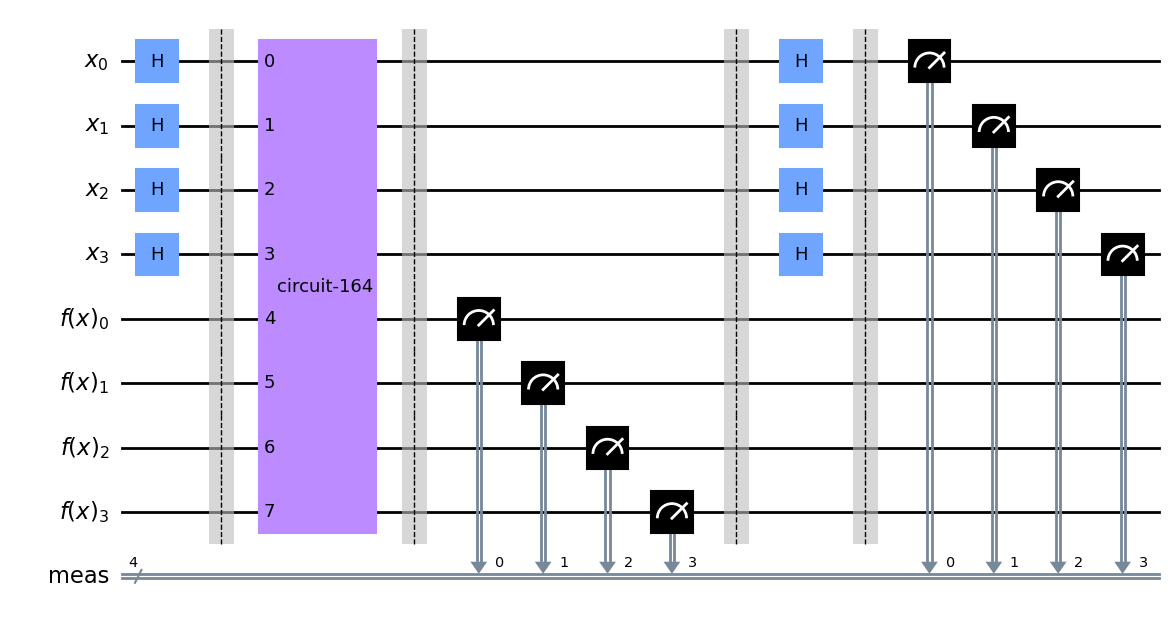

In [7]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
n=n_input

qr_in = QuantumRegister(n, name='x')
qr_out = QuantumRegister(n, name='f(x)')
cr = ClassicalRegister(n, name='meas')
    
# Construimos el circuito
qc = QuantumCircuit(qr_in, qr_out, cr, name='q')
    
#========Escribe tu código aquí========
# Aplica la puerta de Walsh-Hadamard al primer registro
qc.h(qr_in)
qc.barrier()

# Aplicamos el oráculo
qc.append(simon_oracle_gate,qr_in[:]+qr_out[:])    
qc.barrier()

# Medimos el registro de los cúbits de |f(x)>  este paso se puede omitir, compruébalo 
qc.measure(qr_out, cr)
qc.barrier()


# Volvemos a aplicar la puerta de Walsh-Hadamard al primer registro
qc.h(qr_in)
qc.barrier()

# Finalmente medimos el registro de los inputs |x>

qc.measure(qr_in, cr)   

#======================================
    
qc.draw('mpl')


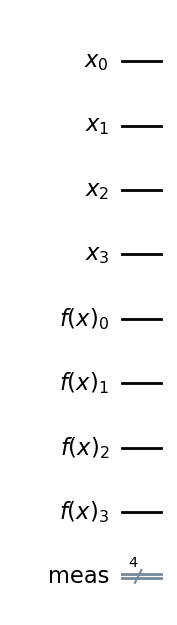

In [8]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
n=n_input

qr_in = QuantumRegister(n, name='x')
qr_out = QuantumRegister(n, name='f(x)')
cr = ClassicalRegister(n, name='meas')
    
# Construimos el circuito
qc = QuantumCircuit(qr_in, qr_out, cr, name='q')
    
#========Escribe tu código aquí========
    

#======================================
    
qc.draw('mpl')


In [9]:
from qiskit import Aer, execute

shots_exe = 1000

backend = Aer.get_backend('qasm_simulator')
job     = execute(qc, backend, shots = shots_exe)
result  = job.result()
counts  = result.get_counts()

from qiskit.tools.visualization import plot_histogram

plot_histogram(counts)

QiskitError: 'No counts for experiment "0"'

In [10]:
def solve_for_solution(counts):

#   extraemos la longitud de las cuentas 'x' que será igual a la de la incógnita 's'
    n = len(list(counts)[0]) 

#   generamos todos los posibles inputs
    s_list = [format(i, 'b').zfill(n) for i in range(1, 2**n)]
#    s_list = [format(i, '0'+str(n)+'b') for i in range(1, 2**n)]  # otra manera de hacer lo mismo
    
#   ahora evaluamos, para cada s,  s.x_i = 0 con todos los x_i encontrados
    for s_str in s_list:
        s = [int(_) for _ in list(s_str)]
#        print(' s=',s)

#   sólo necesitamos n valores de x independientes'
        prod_sxi = [sum([s[j]*int(xi[j]) for j in range(len(s))])%2 for xi in list(counts)[:n]]

#   sólo si todos los s.x_i = 0 también la suma será = 0
        sum_sx = sum(prod_sxi)
        print('(Sum_{i=1}^4 s.x_i%2))=', sum_sx, ' para s=', s_str)
        if  sum_sx==0:
            return s_str
            break

In [11]:
s_sol = solve_for_solution(counts)
print('la periodicidad buscada es =', s_sol)

NameError: name 'counts' is not defined

In [12]:

def oraculo_de_Simon(s):   
    'autor Sergio Barrera'  

    def suma_bit_a_bit_mod2(a, b):    
        suma = ''
        for i in range(len(a)):
            suma += str((int(a[i]) + int(b[i])) % 2)
        return suma

    n = len(s) 
    inputs  = [format(i, 'b').zfill(n) for i in range(2**n)]
    aux = []
    outputs = []    
    for inp in inputs:
        if inp in [suma_bit_a_bit_mod2(a, s) for a in aux]:
###         
#        tu solución aquí 
##
        else:
            outputs.append(inp)
            aux.append(inp)
    return outputs



IndentationError: expected an indented block after 'if' statement on line 15 (3524478726.py, line 19)